## Testing the xml rendering

In [1]:
# @title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

%load_ext autoreload
%autoreload 2

Tue Jul 29 14:22:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off |   00000000:01:00.0 Off |                  N/A |
|  0%   37C    P8             13W /  285W |     221MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

/tmp/ipykernel_2904848/2013611669.py:3: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.util


In [2]:
import jax
jax.devices()

[CudaDevice(id=0)]

In [6]:
# @title Import MuJoCo, MJX, and Brax
from datetime import datetime
import functools
import os
from typing import Any, Dict, Sequence, Tuple, Union
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.base import State as PipelineState
from brax.envs.base import Env, PipelineEnv, State
from brax.io import html, mjcf, model
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import networks as sac_networks
from brax.training.agents.sac import train as sac
from etils import epath
from flax import struct
from flax.training import orbax_utils
from IPython.display import HTML, clear_output
import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import numpy as np
from orbax import checkpoint as ocp

from mujoco_playground import wrapper
from mujoco_playground import registry

In [7]:
env_file = 'xmls/go1_reacher.xml'

spec = mj.MjSpec.from_file(env_file)
model = spec.compile()
data = mj.MjData(model)

cam = mj.MjvCamera()
mj.mjv_defaultCamera(cam)
cam.lookat = [0, 0, 0]
cam.distance = 5
cam.elevation = -30

### Render a 5-second simulation
duration = 5  # (seconds)
framerate = 60  # (Hz)
frames = []
with mj.Renderer(model, width=1920 // 3, height=1080 // 3) as renderer:
  while data.time < duration:
    mj.mj_step(model, data)
    if len(frames) < data.time * framerate:
      # cam.azimuth = 20 + 20 * (1 - np.cos(np.pi*data.time / duration))
      renderer.update_scene(data, cam)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate )

### Alternatively, just show a single frame after 5 seconds
# for i in range(1000):
#   mj.mj_step(model, data)

# Show result
# render(model, data)

In [68]:
GO2_TARGET_XML = """
<mujoco model="go2_target_environment">
  <compiler angle="radian" meshdir="xmls/assets" autolimits="true"/>

  <option cone="elliptic" impratio="100"/>

  <default>
    <default class="go2">
      <geom friction="0.6" margin="0.001" condim="1"/>
      <joint axis="0 1 0" damping="2" armature="0.01" frictionloss="0.2"/>
      <motor ctrlrange="-23.7 23.7"/>
      <default class="abduction">
        <joint axis="1 0 0" range="-1.0472 1.0472"/>
      </default>
      <default class="hip">
        <default class="front_hip">
          <joint range="-1.5708 3.4907"/>
        </default>
        <default class="back_hip">
          <joint range="-0.5236 4.5379"/>
        </default>
      </default>
      <default class="knee">
        <joint range="-2.7227 -0.83776"/>
        <motor ctrlrange="-45.43 45.43"/>
      </default>
      <default class="visual">
        <geom type="mesh" contype="0" conaffinity="0" group="2"/>
      </default>
      <default class="collision">
        <geom group="3"/>
        <default class="foot">
          <geom size="0.022" pos="-0.002 0 -0.213" priority="1" solimp="0.015 1 0.022" condim="6"
            friction="0.8 0.02 0.01"/>
        </default>
      </default>
    </default>
  </default>

  <asset>
    <material name="metal" rgba=".9 .95 .95 1"/>
    <material name="black" rgba="0 0 0 1"/>
    <material name="white" rgba="1 1 1 1"/>
    <material name="gray" rgba="0.671705 0.692426 0.774270 1"/>
    <material name="red_material" rgba="1 0 0 1"/>
    <material name="green_material" rgba="0 1 0 1"/>

    <texture type="skybox" builtin="gradient" width="512" height="512" rgb1=".4 .6 .8" rgb2="0 0 0"/>
    <texture name="texgeom" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="0.6 0.6 0.6" rgb2="0.6 0.6 0.6" markrgb="1 1 1"/>
    <texture name="texplane" type="2d" builtin="checker" rgb1=".4 .4 .4" rgb2=".6 .6 .6" width="512" height="512"/>
    <material name="MatPlane" reflectance="0.3" texture="texplane" texrepeat="1 1" texuniform="true" rgba=".7 .7 .7 1"/>


    <!-- Mesh files are referenced from the go2.xml. In a real setup, these would need to be in the 'assets' directory -->
    <mesh file="base_0.obj"/>
    <mesh file="base_1.obj"/>
    <mesh file="base_2.obj"/>
    <mesh file="base_3.obj"/>
    <mesh file="base_4.obj"/>
    <mesh file="hip_0.obj"/>
    <mesh file="hip_1.obj"/>
    <mesh file="thigh_0.obj"/>
    <mesh file="thigh_1.obj"/>
    <mesh file="thigh_mirror_0.obj"/>
    <mesh file="thigh_mirror_1.obj"/>
    <mesh file="calf_0.obj"/>
    <mesh file="calf_1.obj"/>
    <mesh file="calf_mirror_0.obj"/>
    <mesh file="calf_mirror_1.obj"/>
    <mesh file="foot.obj"/>
  </asset>

  <worldbody>
    <light directional="true" diffuse=".8 .8 .8" pos="0 0 10" dir="0 0 -10"/>
    <geom name="floor" type="plane" size="3 3 .5" material="MatPlane" rgba=".7 .7 .7 1"/>

    <!-- Go2 Robot definition (copied from go2.xml) -->
    <body name="go2_base" pos="0 0 0.445" childclass="go2">
      <inertial pos="0.021112 0 -0.005366" quat="-0.000543471 0.713435 -0.00173769 0.700719" mass="6.921"
        diaginertia="0.107027 0.0980771 0.0244531"/>
      <freejoint/>
      <geom mesh="base_0" material="black" class="visual"/>
      <geom mesh="base_1" material="black" class="visual"/>
      <geom mesh="base_2" material="black" class="visual"/>
      <geom mesh="base_3" material="white" class="visual"/>
      <geom mesh="base_4" material="gray" class="visual"/>
      <!-- Changed collision types to sphere -->
      <geom size="0.05" type="sphere" class="collision"/> <!-- Original: box size="0.1881 0.04675 0.057" -->
      <geom size="0.045" pos="0.285 0 0.01" type="sphere" class="collision"/> <!-- Original: cylinder size="0.05 0.045" -->
      <geom size="0.047" pos="0.293 0 -0.06" class="collision"/>
      <site name="imu" pos="-0.02557 0 0.04232"/>
      <body name="FL_hip" pos="0.1934 0.0465 0">
        <inertial pos="-0.0054 0.00194 -0.000105" quat="0.497014 0.499245 0.505462 0.498237" mass="0.678"
          diaginertia="0.00088403 0.000596003 0.000479967"/>
        <joint name="FL_hip_joint" class="abduction"/>
        <geom mesh="hip_0" material="metal" class="visual"/>
        <geom mesh="hip_1" material="gray" class="visual"/>
        <geom size="0.02" pos="0 0.08 0" quat="1 1 0 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.046 0.02" -->
        <body name="FL_thigh" pos="0 0.0955 0">
          <inertial pos="-0.00374 -0.0223 -0.0327" quat="0.829533 0.0847635 -0.0200632 0.551623" mass="1.152"
            diaginertia="0.00594973 0.00584149 0.000878787"/>
          <joint name="FL_thigh_joint" class="front_hip"/>
          <geom mesh="thigh_0" material="metal" class="visual"/>
          <geom mesh="thigh_1" material="gray" class="visual"/>
          <geom size="0.012" pos="0 0 -0.1065" quat="0.707107 0 0.707107 0" type="sphere" class="collision"/> <!-- Original: box size="0.1065 0.01225 0.017" -->
          <body name="FL_calf" pos="0 0 -0.213">
            <inertial pos="0.00629595 -0.000622121 -0.141417" quat="0.710672 0.00154099 -0.00450087 0.703508"
              mass="0.241352" diaginertia="0.0014901 0.00146356 5.31397e-05"/>
            <joint name="FL_calf_joint" class="knee"/>
            <geom mesh="calf_0" material="gray" class="visual"/>
            <geom mesh="calf_1" material="black" class="visual"/>
            <geom size="0.012" pos="0.008 0 -0.06" quat="0.994493 0 -0.104807 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.012 0.06" -->
            <geom size="0.011" pos="0.02 0 -0.148" quat="0.999688 0 0.0249974 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.011 0.0325" -->
            <geom pos="0 0 -0.213" mesh="foot" class="visual" material="black"/>
            <geom name="FL" class="foot"/>
          </body>
        </body>
      </body>
      <body name="FR_hip" pos="0.1934 -0.0465 0">
        <inertial pos="-0.0054 -0.00194 -0.000105" quat="0.498237 0.505462 0.499245 0.497014" mass="0.678"
          diaginertia="0.00088403 0.000596003 0.000479967"/>
        <joint name="FR_hip_joint" class="abduction"/>
        <geom mesh="hip_0" material="metal" class="visual" quat="4.63268e-05 1 0 0"/>
        <geom mesh="hip_1" material="gray" class="visual" quat="4.63268e-05 1 0 0"/>
        <geom size="0.02" pos="0 -0.08 0" quat="0.707107 0.707107 0 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.046 0.02" -->
        <body name="FR_thigh" pos="0 -0.0955 0">
          <inertial pos="-0.00374 0.0223 -0.0327" quat="0.551623 -0.0200632 0.0847635 0.829533" mass="1.152"
            diaginertia="0.00594973 0.00584149 0.000878787"/>
          <joint name="FR_thigh_joint" class="front_hip"/>
          <geom mesh="thigh_mirror_0" material="metal" class="visual"/>
          <geom mesh="thigh_mirror_1" material="gray" class="visual"/>
          <geom size="0.012" pos="0 0 -0.1065" quat="0.707107 0 0.707107 0" type="sphere" class="collision"/> <!-- Original: box size="0.1065 0.01225 0.017" -->
          <body name="FR_calf" pos="0 0 -0.213">
            <inertial pos="0.00629595 0.000622121 -0.141417" quat="0.703508 -0.00450087 0.00154099 0.710672"
              mass="0.241352" diaginertia="0.0014901 0.00146356 5.31397e-05"/>
            <joint name="FR_calf_joint" class="knee"/>
            <geom mesh="calf_mirror_0" material="gray" class="visual"/>
            <geom mesh="calf_mirror_1" material="black" class="visual"/>
            <geom size="0.013" pos="0.01 0 -0.06" quat="0.995004 0 -0.0998334 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.013 0.06" -->
            <geom size="0.011" pos="0.02 0 -0.148" quat="0.999688 0 0.0249974 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.011 0.0325" -->
            <geom pos="0 0 -0.213" mesh="foot" class="visual" material="black"/>
            <geom name="FR" class="foot"/>
          </body>
        </body>
      </body>
      <body name="RL_hip" pos="-0.1934 0.0465 0">
        <inertial pos="0.0054 0.00194 -0.000105" quat="0.505462 0.498237 0.497014 0.499245" mass="0.678"
          diaginertia="0.00088403 0.000596003 0.000479967"/>
        <joint name="RL_hip_joint" class="abduction"/>
        <geom mesh="hip_0" material="metal" class="visual" quat="4.63268e-05 0 1 0"/>
        <geom mesh="hip_1" material="gray" class="visual" quat="4.63268e-05 0 1 0"/>
        <geom size="0.02" pos="0 0.08 0" quat="0.707107 0.707107 0 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.046 0.02" -->
        <body name="RL_thigh" pos="0 0.0955 0">
          <inertial pos="-0.00374 -0.0223 -0.0327" quat="0.829533 0.0847635 -0.0200632 0.551623" mass="1.152"
            diaginertia="0.00594973 0.00584149 0.000878787"/>
          <joint name="RL_thigh_joint" class="back_hip"/>
          <geom mesh="thigh_0" material="metal" class="visual"/>
          <geom mesh="thigh_1" material="gray" class="visual"/>
          <geom size="0.012" pos="0 0 -0.1065" quat="0.707107 0 0.707107 0" type="sphere" class="collision"/> <!-- Original: box size="0.1065 0.01225 0.017" -->
          <body name="RL_calf" pos="0 0 -0.213">
            <inertial pos="0.00629595 -0.000622121 -0.141417" quat="0.710672 0.00154099 -0.00450087 0.703508"
              mass="0.241352" diaginertia="0.0014901 0.00146356 5.31397e-05"/>
            <joint name="RL_calf_joint" class="knee"/>
            <geom mesh="calf_0" material="gray" class="visual"/>
            <geom mesh="calf_1" material="black" class="visual"/>
            <geom size="0.013" pos="0.01 0 -0.06" quat="0.995004 0 -0.0998334 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.013 0.06" -->
            <geom size="0.011" pos="0.02 0 -0.148" quat="0.999688 0 0.0249974 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.011 0.0325" -->
            <geom pos="0 0 -0.213" mesh="foot" class="visual" material="black"/>
            <geom name="RL" class="foot"/>
          </body>
        </body>
      </body>
      <body name="RR_hip" pos="-0.1934 -0.0465 0">
        <inertial pos="0.0054 -0.00194 -0.000105" quat="0.499245 0.497014 0.498237 0.505462" mass="0.678"
          diaginertia="0.00088403 0.000596003 0.000479967"/>
        <joint name="RR_hip_joint" class="abduction"/>
        <geom mesh="hip_0" material="metal" class="visual" quat="2.14617e-09 4.63268e-05 4.63268e-05 -1"/>
        <geom mesh="hip_1" material="gray" class="visual" quat="2.14617e-09 4.63268e-05 4.63268e-05 -1"/>
        <geom size="0.02" pos="0 -0.08 0" quat="0.707107 0.707107 0 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.046 0.02" -->
        <body name="RR_thigh" pos="0 -0.0955 0">
          <inertial pos="-0.00374 0.0223 -0.0327" quat="0.551623 -0.0200632 0.0847635 0.829533" mass="1.152"
            diaginertia="0.00594973 0.00584149 0.000878787"/>
          <joint name="RR_thigh_joint" class="back_hip"/>
          <geom mesh="thigh_mirror_0" material="metal" class="visual"/>
          <geom mesh="thigh_mirror_1" material="gray" class="visual"/>
          <geom size="0.012" pos="0 0 -0.1065" quat="0.707107 0 0.707107 0" type="sphere" class="collision"/> <!-- Original: box size="0.1065 0.01225 0.017" -->
          <body name="RR_calf" pos="0 0 -0.213">
            <inertial pos="0.00629595 0.000622121 -0.141417" quat="0.703508 -0.00450087 0.00154099 0.710672"
              mass="0.241352" diaginertia="0.0014901 0.00146356 5.31397e-05"/>
            <joint name="RR_calf_joint" class="knee"/>
            <geom mesh="calf_mirror_0" material="gray" class="visual"/>
            <geom mesh="calf_mirror_1" material="black" class="visual"/>
            <geom size="0.013" pos="0.01 0 -0.06" quat="0.995004 0 -0.0998334 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.013 0.06" -->
            <geom size="0.011" pos="0.02 0 -0.148" quat="0.999688 0 0.0249974 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.011 0.0325" -->
            <geom pos="0 0 -0.213" mesh="foot" class="visual" material="black"/>
            <geom name="RR" class="foot"/>
          </body>
        </body>
      </body>
    </body>

    <!-- Red Objects (Reward) -->
    <body name="red_object_1" pos="1.5 1.5 0.1">
      <geom name="red_sphere_1" type="sphere" size="0.1" material="red_material"/>
    </body>
    <body name="red_object_2" pos="-1.5 -1.5 0.1">
      <geom name="red_box_1" type="sphere" size="0.1" material="red_material"/> <!-- Changed type to sphere -->
    </body>

    <!-- Green Objects (Penalty) -->
    <body name="green_object_1" pos="1.5 -1.5 0.1">
      <geom name="green_sphere_1" type="sphere" size="0.1" material="green_material"/>
    </body>
    <body name="green_object_2" pos="-1.5 1.5 0.1">
      <geom name="green_box_1" type="sphere" size="0.1" material="green_material"/> <!-- Changed type to sphere -->
    </body>

  </worldbody>

  <actuator>
    <motor class="abduction" name="FL_hip" joint="FL_hip_joint"/>
    <motor class="hip" name="FL_thigh" joint="FL_thigh_joint"/>
    <motor class="knee" name="FL_calf" joint="FL_calf_joint"/>
    <motor class="abduction" name="FR_hip" joint="FR_hip_joint"/>
    <motor class="hip" name="FR_thigh" joint="FR_thigh_joint"/>
    <motor class="knee" name="FR_calf" joint="FR_calf_joint"/>
    <motor class="abduction" name="RL_hip" joint="RL_hip_joint"/>
    <motor class="hip" name="RL_thigh" joint="RL_thigh_joint"/>
    <motor class="knee" name="RL_calf" joint="RL_calf_joint"/>
    <motor class="abduction" name="RR_hip" joint="RR_hip_joint"/>
    <motor class="hip" name="RR_thigh" joint="RR_thigh_joint"/>
    <motor class="knee" name="RR_calf" joint="RR_calf_joint"/>
  </actuator>

  <keyframe>
    <key name="home" qpos="0 0 0.27 1 0 0 0 0 0.9 -1.8 0 0.9 -1.8 0 0.9 -1.8 0 0.9 -1.8"
      ctrl="0 0.9 -1.8 0 0.9 -1.8 0 0.9 -1.8 0 0.9 -1.8"/>
  </keyframe>
</mujoco>
"""

""

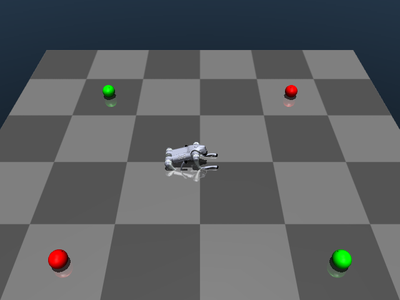

In [69]:
spec = mj.MjSpec.from_string(GO2_TARGET_XML)
model = spec.compile()
data = mj.MjData(model)

# Run for 5 seconds
for i in range(1000):
  mj.mj_step(model, data)

# Show result
render(model, data)

In [72]:
class Go2TargetEnv(PipelineEnv):
  """
  A JAX-based reinforcement learning environment for the Go2 robot.

  The robot is rewarded for approaching red objects and penalized for
  approaching green objects. This version extends PipelineEnv.
  """

  def __init__(self, **kwargs):
    # Load the MuJoCo model into a temporary mjcf.model.Model object first
    # to access name-to-id lookups before compiling to brax.base.System.
    model = mjcf.loads(GO2_TARGET_XML)

    # Find the indices of the target objects for easy access
    self.red_object_names = ['red_sphere_1', 'red_box_1']
    self.green_object_names = ['green_sphere_1', 'green_box_1']

    # Perform geom_name_to_id lookups on the 'model' object
    self.red_object_geom_idxs = jp.array([
        model.geom_name_to_id(name) for name in self.red_object_names
    ])
    self.green_object_geom_idxs = jp.array([
        model.geom_name_to_id(name) for name in self.green_object_names
    ])

    # Get the index of the Go2 robot's base body for position tracking
    self.go2_base_body_idx = model.body_name_to_id('go2_base')

    # Now compile the model to a brax.base.System and pass it to PipelineEnv
    super().__init__(sys=model, **kwargs) # model is automatically converted to brax.base.System by PipelineEnv

    # Define the number of steps per episode
    self.episode_length = 1000

  def _get_obs(self, pipeline_state: base.State) -> jp.ndarray:
    qpos = pipeline_state.qpos
    qvel = pipeline_state.qvel

    go2_base_pos = pipeline_state.x.pos[self.go2_base_body_idx]
    go2_base_vel = pipeline_state.xd.vel[self.go2_base_body_idx]
    go2_base_ang_vel = pipeline_state.xd.ang[self.go2_base_body_idx]

    joint_qpos = qpos[7:]
    joint_qvel = qvel[6:]

    red_object_positions = pipeline_state.geom_pos[self.red_object_geom_idxs]
    green_object_positions = pipeline_state.geom_pos[self.green_object_geom_idxs]

    relative_red_pos = red_object_positions[:, :2] - go2_base_pos[:2]
    relative_green_pos = green_object_positions[:, :2] - go2_base_pos[:2]

    obs = jp.concatenate([
        go2_base_pos,
        go2_base_vel,
        go2_base_ang_vel,
        joint_qpos,
        joint_qvel,
        relative_red_pos.flatten(),
        relative_green_pos.flatten(),
    ])
    return obs

  def reset(self, rng: jax.Array) -> State:
    rng, rng1, rng2 = jax.random.split(rng, 3)

    qpos = self.sys.keyframe_qpos[self.sys.keyframe_name_to_id('home')]
    qvel = jp.zeros(self.sys.nv)

    qpos = qpos.at[:2].set(jax.random.uniform(rng1, (2,), minval=-0.5, maxval=0.5))

    pipeline_state = self.pipeline_init(qpos, qvel)
    obs = self._get_obs(pipeline_state)
    reward, done, zero_metrics = jp.zeros(3)
    metrics = {
        'reward_red_proximity': zero_metrics,
        'reward_green_penalty': zero_metrics,
        'reward_ctrl': zero_metrics,
        'reward_upright': zero_metrics,
        'steps': jp.array(0),
    }
    return State(pipeline_state, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    pipeline_state = self.pipeline_step(state.pipeline_state, action)

    go2_base_pos = pipeline_state.x.pos[self.go2_base_body_idx]
    go2_base_quat = pipeline_state.x.rot[self.go2_base_body_idx]
    go2_base_vel = pipeline_state.xd.vel[self.go2_base_body_idx]

    upright_reward = jp.dot(base.Transform(rot=go2_base_quat).rot[:, 2], jp.array([0., 0., 1.]))
    upright_reward = jp.clip(upright_reward, 0.0, 1.0)

    red_object_positions = pipeline_state.geom_pos[self.red_object_geom_idxs]
    red_distances = jp.linalg.norm(red_object_positions[:, :2] - go2_base_pos[:2], axis=-1)
    reward_red_proximity = jp.sum(jp.exp(-red_distances * 2.0))

    green_object_positions = pipeline_state.geom_pos[self.green_object_geom_idxs]
    green_distances = jp.linalg.norm(green_object_positions[:, :2] - go2_base_pos[:2], axis=-1)
    reward_green_penalty = -jp.sum(jp.exp(-green_distances * 2.0))

    ctrl_cost = -0.01 * jp.sum(jp.square(action))

    reward = reward_red_proximity + reward_green_penalty + ctrl_cost + upright_reward

    min_z_pos = 0.25
    done = jp.where(go2_base_pos[2] < min_z_pos, 1.0, 0.0)

    obs = self._get_obs(pipeline_state)

    metrics = state.metrics.copy()
    metrics['reward_red_proximity'] = reward_red_proximity
    metrics['reward_green_penalty'] = reward_green_penalty
    metrics['reward_ctrl'] = ctrl_cost
    metrics['reward_upright'] = upright_reward
    metrics['steps'] = metrics['steps'] + 1

    done = jp.where(metrics['steps'] >= self.episode_length, 1.0, done)

    return State(pipeline_state, obs, reward, done, metrics)

# Example usage (for testing purposes, not part of the environment class itself)
if __name__ == '__main__':
  env = Go2TargetEnv(
      backend='mjx',
      dt=0.01,
      gravity=(0, 0, -9.81)
  )

  jit_reset = jax.jit(env.reset)
  jit_step = jax.jit(env.step)

  key = jax.random.PRNGKey(0)

  key, reset_key = jax.random.split(key)
  state = jit_reset(reset_key)
  print(f"Initial observation shape: {state.obs.shape}")
  print(f"Action space size: {env.action_size}")

  num_steps = 100
  for i in range(num_steps):
    key, action_key = jax.random.split(key)
    action = jax.random.uniform(action_key, (env.action_size,), minval=-1.0, maxval=1.0)
    state = jit_step(state, action)

    if i % 10 == 0:
      print(f"Step {i}: Reward = {state.reward:.4f}, Done = {state.done}")
      print(f"  Go2 Base Position (x,y,z): {state.pipeline_state.x.pos[env.go2_base_body_idx]}")
      print(f"  Reward Metrics: {state.metrics}")

    if state.done:
      print(f"Episode finished at step {i+1}. Resetting...")
      key, reset_key = jax.random.split(key)
      state = jit_reset(reset_key)

  print("\nSimulation complete.")


OSError: [Errno 36] File name too long: '\n<mujoco model="go2_target_environment">\n  <compiler angle="radian" meshdir="xmls/assets" autolimits="true"/>\n\n  <option cone="elliptic" impratio="100"/>\n\n  <default>\n    <default class="go2">\n      <geom friction="0.6" margin="0.001" condim="1"/>\n      <joint axis="0 1 0" damping="2" armature="0.01" frictionloss="0.2"/>\n      <motor ctrlrange="-23.7 23.7"/>\n      <default class="abduction">\n        <joint axis="1 0 0" range="-1.0472 1.0472"/>\n      </default>\n      <default class="hip">\n        <default class="front_hip">\n          <joint range="-1.5708 3.4907"/>\n        </default>\n        <default class="back_hip">\n          <joint range="-0.5236 4.5379"/>\n        </default>\n      </default>\n      <default class="knee">\n        <joint range="-2.7227 -0.83776"/>\n        <motor ctrlrange="-45.43 45.43"/>\n      </default>\n      <default class="visual">\n        <geom type="mesh" contype="0" conaffinity="0" group="2"/>\n      </default>\n      <default class="collision">\n        <geom group="3"/>\n        <default class="foot">\n          <geom size="0.022" pos="-0.002 0 -0.213" priority="1" solimp="0.015 1 0.022" condim="6"\n            friction="0.8 0.02 0.01"/>\n        </default>\n      </default>\n    </default>\n  </default>\n\n  <asset>\n    <material name="metal" rgba=".9 .95 .95 1"/>\n    <material name="black" rgba="0 0 0 1"/>\n    <material name="white" rgba="1 1 1 1"/>\n    <material name="gray" rgba="0.671705 0.692426 0.774270 1"/>\n    <material name="red_material" rgba="1 0 0 1"/>\n    <material name="green_material" rgba="0 1 0 1"/>\n\n    <texture type="skybox" builtin="gradient" width="512" height="512" rgb1=".4 .6 .8" rgb2="0 0 0"/>\n    <texture name="texgeom" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="0.6 0.6 0.6" rgb2="0.6 0.6 0.6" markrgb="1 1 1"/>\n    <texture name="texplane" type="2d" builtin="checker" rgb1=".4 .4 .4" rgb2=".6 .6 .6" width="512" height="512"/>\n    <material name="MatPlane" reflectance="0.3" texture="texplane" texrepeat="1 1" texuniform="true" rgba=".7 .7 .7 1"/>\n\n\n    <!-- Mesh files are referenced from the go2.xml. In a real setup, these would need to be in the \'assets\' directory -->\n    <mesh file="base_0.obj"/>\n    <mesh file="base_1.obj"/>\n    <mesh file="base_2.obj"/>\n    <mesh file="base_3.obj"/>\n    <mesh file="base_4.obj"/>\n    <mesh file="hip_0.obj"/>\n    <mesh file="hip_1.obj"/>\n    <mesh file="thigh_0.obj"/>\n    <mesh file="thigh_1.obj"/>\n    <mesh file="thigh_mirror_0.obj"/>\n    <mesh file="thigh_mirror_1.obj"/>\n    <mesh file="calf_0.obj"/>\n    <mesh file="calf_1.obj"/>\n    <mesh file="calf_mirror_0.obj"/>\n    <mesh file="calf_mirror_1.obj"/>\n    <mesh file="foot.obj"/>\n  </asset>\n\n  <worldbody>\n    <light directional="true" diffuse=".8 .8 .8" pos="0 0 10" dir="0 0 -10"/>\n    <geom name="floor" type="plane" size="3 3 .5" material="MatPlane" rgba=".7 .7 .7 1"/>\n\n    <!-- Go2 Robot definition (copied from go2.xml) -->\n    <body name="go2_base" pos="0 0 0.445" childclass="go2">\n      <inertial pos="0.021112 0 -0.005366" quat="-0.000543471 0.713435 -0.00173769 0.700719" mass="6.921"\n        diaginertia="0.107027 0.0980771 0.0244531"/>\n      <freejoint/>\n      <geom mesh="base_0" material="black" class="visual"/>\n      <geom mesh="base_1" material="black" class="visual"/>\n      <geom mesh="base_2" material="black" class="visual"/>\n      <geom mesh="base_3" material="white" class="visual"/>\n      <geom mesh="base_4" material="gray" class="visual"/>\n      <!-- Changed collision types to sphere -->\n      <geom size="0.05" type="sphere" class="collision"/> <!-- Original: box size="0.1881 0.04675 0.057" -->\n      <geom size="0.045" pos="0.285 0 0.01" type="sphere" class="collision"/> <!-- Original: cylinder size="0.05 0.045" -->\n      <geom size="0.047" pos="0.293 0 -0.06" class="collision"/>\n      <site name="imu" pos="-0.02557 0 0.04232"/>\n      <body name="FL_hip" pos="0.1934 0.0465 0">\n        <inertial pos="-0.0054 0.00194 -0.000105" quat="0.497014 0.499245 0.505462 0.498237" mass="0.678"\n          diaginertia="0.00088403 0.000596003 0.000479967"/>\n        <joint name="FL_hip_joint" class="abduction"/>\n        <geom mesh="hip_0" material="metal" class="visual"/>\n        <geom mesh="hip_1" material="gray" class="visual"/>\n        <geom size="0.02" pos="0 0.08 0" quat="1 1 0 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.046 0.02" -->\n        <body name="FL_thigh" pos="0 0.0955 0">\n          <inertial pos="-0.00374 -0.0223 -0.0327" quat="0.829533 0.0847635 -0.0200632 0.551623" mass="1.152"\n            diaginertia="0.00594973 0.00584149 0.000878787"/>\n          <joint name="FL_thigh_joint" class="front_hip"/>\n          <geom mesh="thigh_0" material="metal" class="visual"/>\n          <geom mesh="thigh_1" material="gray" class="visual"/>\n          <geom size="0.012" pos="0 0 -0.1065" quat="0.707107 0 0.707107 0" type="sphere" class="collision"/> <!-- Original: box size="0.1065 0.01225 0.017" -->\n          <body name="FL_calf" pos="0 0 -0.213">\n            <inertial pos="0.00629595 -0.000622121 -0.141417" quat="0.710672 0.00154099 -0.00450087 0.703508"\n              mass="0.241352" diaginertia="0.0014901 0.00146356 5.31397e-05"/>\n            <joint name="FL_calf_joint" class="knee"/>\n            <geom mesh="calf_0" material="gray" class="visual"/>\n            <geom mesh="calf_1" material="black" class="visual"/>\n            <geom size="0.012" pos="0.008 0 -0.06" quat="0.994493 0 -0.104807 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.012 0.06" -->\n            <geom size="0.011" pos="0.02 0 -0.148" quat="0.999688 0 0.0249974 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.011 0.0325" -->\n            <geom pos="0 0 -0.213" mesh="foot" class="visual" material="black"/>\n            <geom name="FL" class="foot"/>\n          </body>\n        </body>\n      </body>\n      <body name="FR_hip" pos="0.1934 -0.0465 0">\n        <inertial pos="-0.0054 -0.00194 -0.000105" quat="0.498237 0.505462 0.499245 0.497014" mass="0.678"\n          diaginertia="0.00088403 0.000596003 0.000479967"/>\n        <joint name="FR_hip_joint" class="abduction"/>\n        <geom mesh="hip_0" material="metal" class="visual" quat="4.63268e-05 1 0 0"/>\n        <geom mesh="hip_1" material="gray" class="visual" quat="4.63268e-05 1 0 0"/>\n        <geom size="0.02" pos="0 -0.08 0" quat="0.707107 0.707107 0 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.046 0.02" -->\n        <body name="FR_thigh" pos="0 -0.0955 0">\n          <inertial pos="-0.00374 0.0223 -0.0327" quat="0.551623 -0.0200632 0.0847635 0.829533" mass="1.152"\n            diaginertia="0.00594973 0.00584149 0.000878787"/>\n          <joint name="FR_thigh_joint" class="front_hip"/>\n          <geom mesh="thigh_mirror_0" material="metal" class="visual"/>\n          <geom mesh="thigh_mirror_1" material="gray" class="visual"/>\n          <geom size="0.012" pos="0 0 -0.1065" quat="0.707107 0 0.707107 0" type="sphere" class="collision"/> <!-- Original: box size="0.1065 0.01225 0.017" -->\n          <body name="FR_calf" pos="0 0 -0.213">\n            <inertial pos="0.00629595 0.000622121 -0.141417" quat="0.703508 -0.00450087 0.00154099 0.710672"\n              mass="0.241352" diaginertia="0.0014901 0.00146356 5.31397e-05"/>\n            <joint name="FR_calf_joint" class="knee"/>\n            <geom mesh="calf_mirror_0" material="gray" class="visual"/>\n            <geom mesh="calf_mirror_1" material="black" class="visual"/>\n            <geom size="0.013" pos="0.01 0 -0.06" quat="0.995004 0 -0.0998334 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.013 0.06" -->\n            <geom size="0.011" pos="0.02 0 -0.148" quat="0.999688 0 0.0249974 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.011 0.0325" -->\n            <geom pos="0 0 -0.213" mesh="foot" class="visual" material="black"/>\n            <geom name="FR" class="foot"/>\n          </body>\n        </body>\n      </body>\n      <body name="RL_hip" pos="-0.1934 0.0465 0">\n        <inertial pos="0.0054 0.00194 -0.000105" quat="0.505462 0.498237 0.497014 0.499245" mass="0.678"\n          diaginertia="0.00088403 0.000596003 0.000479967"/>\n        <joint name="RL_hip_joint" class="abduction"/>\n        <geom mesh="hip_0" material="metal" class="visual" quat="4.63268e-05 0 1 0"/>\n        <geom mesh="hip_1" material="gray" class="visual" quat="4.63268e-05 0 1 0"/>\n        <geom size="0.02" pos="0 0.08 0" quat="0.707107 0.707107 0 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.046 0.02" -->\n        <body name="RL_thigh" pos="0 0.0955 0">\n          <inertial pos="-0.00374 -0.0223 -0.0327" quat="0.829533 0.0847635 -0.0200632 0.551623" mass="1.152"\n            diaginertia="0.00594973 0.00584149 0.000878787"/>\n          <joint name="RL_thigh_joint" class="back_hip"/>\n          <geom mesh="thigh_0" material="metal" class="visual"/>\n          <geom mesh="thigh_1" material="gray" class="visual"/>\n          <geom size="0.012" pos="0 0 -0.1065" quat="0.707107 0 0.707107 0" type="sphere" class="collision"/> <!-- Original: box size="0.1065 0.01225 0.017" -->\n          <body name="RL_calf" pos="0 0 -0.213">\n            <inertial pos="0.00629595 -0.000622121 -0.141417" quat="0.710672 0.00154099 -0.00450087 0.703508"\n              mass="0.241352" diaginertia="0.0014901 0.00146356 5.31397e-05"/>\n            <joint name="RL_calf_joint" class="knee"/>\n            <geom mesh="calf_0" material="gray" class="visual"/>\n            <geom mesh="calf_1" material="black" class="visual"/>\n            <geom size="0.013" pos="0.01 0 -0.06" quat="0.995004 0 -0.0998334 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.013 0.06" -->\n            <geom size="0.011" pos="0.02 0 -0.148" quat="0.999688 0 0.0249974 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.011 0.0325" -->\n            <geom pos="0 0 -0.213" mesh="foot" class="visual" material="black"/>\n            <geom name="RL" class="foot"/>\n          </body>\n        </body>\n      </body>\n      <body name="RR_hip" pos="-0.1934 -0.0465 0">\n        <inertial pos="0.0054 -0.00194 -0.000105" quat="0.499245 0.497014 0.498237 0.505462" mass="0.678"\n          diaginertia="0.00088403 0.000596003 0.000479967"/>\n        <joint name="RR_hip_joint" class="abduction"/>\n        <geom mesh="hip_0" material="metal" class="visual" quat="2.14617e-09 4.63268e-05 4.63268e-05 -1"/>\n        <geom mesh="hip_1" material="gray" class="visual" quat="2.14617e-09 4.63268e-05 4.63268e-05 -1"/>\n        <geom size="0.02" pos="0 -0.08 0" quat="0.707107 0.707107 0 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.046 0.02" -->\n        <body name="RR_thigh" pos="0 -0.0955 0">\n          <inertial pos="-0.00374 0.0223 -0.0327" quat="0.551623 -0.0200632 0.0847635 0.829533" mass="1.152"\n            diaginertia="0.00594973 0.00584149 0.000878787"/>\n          <joint name="RR_thigh_joint" class="back_hip"/>\n          <geom mesh="thigh_mirror_0" material="metal" class="visual"/>\n          <geom mesh="thigh_mirror_1" material="gray" class="visual"/>\n          <geom size="0.012" pos="0 0 -0.1065" quat="0.707107 0 0.707107 0" type="sphere" class="collision"/> <!-- Original: box size="0.1065 0.01225 0.017" -->\n          <body name="RR_calf" pos="0 0 -0.213">\n            <inertial pos="0.00629595 0.000622121 -0.141417" quat="0.703508 -0.00450087 0.00154099 0.710672"\n              mass="0.241352" diaginertia="0.0014901 0.00146356 5.31397e-05"/>\n            <joint name="RR_calf_joint" class="knee"/>\n            <geom mesh="calf_mirror_0" material="gray" class="visual"/>\n            <geom mesh="calf_mirror_1" material="black" class="visual"/>\n            <geom size="0.013" pos="0.01 0 -0.06" quat="0.995004 0 -0.0998334 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.013 0.06" -->\n            <geom size="0.011" pos="0.02 0 -0.148" quat="0.999688 0 0.0249974 0" type="sphere" class="collision"/> <!-- Original: cylinder size="0.011 0.0325" -->\n            <geom pos="0 0 -0.213" mesh="foot" class="visual" material="black"/>\n            <geom name="RR" class="foot"/>\n          </body>\n        </body>\n      </body>\n    </body>\n\n    <!-- Red Objects (Reward) -->\n    <body name="red_object_1" pos="1.5 1.5 0.1">\n      <geom name="red_sphere_1" type="sphere" size="0.1" material="red_material"/>\n    </body>\n    <body name="red_object_2" pos="-1.5 -1.5 0.1">\n      <geom name="red_box_1" type="sphere" size="0.1" material="red_material"/> <!-- Changed type to sphere -->\n    </body>\n\n    <!-- Green Objects (Penalty) -->\n    <body name="green_object_1" pos="1.5 -1.5 0.1">\n      <geom name="green_sphere_1" type="sphere" size="0.1" material="green_material"/>\n    </body>\n    <body name="green_object_2" pos="-1.5 1.5 0.1">\n      <geom name="green_box_1" type="sphere" size="0.1" material="green_material"/> <!-- Changed type to sphere -->\n    </body>\n\n  </worldbody>\n\n  <actuator>\n    <motor class="abduction" name="FL_hip" joint="FL_hip_joint"/>\n    <motor class="hip" name="FL_thigh" joint="FL_thigh_joint"/>\n    <motor class="knee" name="FL_calf" joint="FL_calf_joint"/>\n    <motor class="abduction" name="FR_hip" joint="FR_hip_joint"/>\n    <motor class="hip" name="FR_thigh" joint="FR_thigh_joint"/>\n    <motor class="knee" name="FR_calf" joint="FR_calf_joint"/>\n    <motor class="abduction" name="RL_hip" joint="RL_hip_joint"/>\n    <motor class="hip" name="RL_thigh" joint="RL_thigh_joint"/>\n    <motor class="knee" name="RL_calf" joint="RL_calf_joint"/>\n    <motor class="abduction" name="RR_hip" joint="RR_hip_joint"/>\n    <motor class="hip" name="RR_thigh" joint="RR_thigh_joint"/>\n    <motor class="knee" name="RR_calf" joint="RR_calf_joint"/>\n  </actuator>\n\n  <keyframe>\n    <key name="home" qpos="0 0 0.27 1 0 0 0 0 0.9 -1.8 0 0.9 -1.8 0 0.9 -1.8 0 0.9 -1.8"\n      ctrl="0 0.9 -1.8 0 0.9 -1.8 0 0.9 -1.8 0 0.9 -1.8"/>\n  </keyframe>\n</mujoco>\n'

In [3]:
from typing import Any, Dict, Optional, Union

import jax
import jax.numpy as jp
from ml_collections import config_dict
import mujoco as mj
from mujoco import mjx
from mujoco.mjx._src import math
import numpy as np

from mujoco_playground._src import collision
from mujoco_playground._src import mjx_env
from mujoco_playground._src.locomotion.go1 import base as go1_base
from mujoco_playground._src.locomotion.go1 import go1_constants as consts
# import mujoco
# import mujoco_extra
# import numpy as np
# from mujoco_playground import Environment, Observation, Action

def default_config() -> config_dict.ConfigDict:
  return config_dict.create(
      ctrl_dt=0.02,
      sim_dt=0.004,
      episode_length=1000,
      Kp=35.0,
      Kd=0.5,
      action_repeat=1,
      action_scale=0.5,
      history_len=1,
      soft_joint_pos_limit_factor=0.95,
      noise_config=config_dict.create(
          level=1.0,  # Set to 0.0 to disable noise.
          scales=config_dict.create(
              joint_pos=0.03,
              joint_vel=1.5,
              gyro=0.2,
              gravity=0.05,
              linvel=0.1,
          ),
      ),
      reward_config=config_dict.create(
          scales=config_dict.create(
              # Tracking.
              tracking_lin_vel=1.0,
              tracking_ang_vel=0.5,
              # Base reward.
              lin_vel_z=-0.5,
              ang_vel_xy=-0.05,
              orientation=-5.0,
              # Other.
              dof_pos_limits=-1.0,
              pose=0.5,
              contact_reward=1.0,
              # Other.
              termination=-1.0,
              stand_still=-1.0,
              # Regularization.
              torques=-0.0002,
              action_rate=-0.01,
              energy=-0.001,
              # Feet.
              feet_clearance=-2.0,
              feet_height=-0.2,
              feet_slip=-0.1,
              feet_air_time=0.1,
          ),
          tracking_sigma=0.25,
          max_foot_height=0.1,
      ),
      pert_config=config_dict.create(
          enable=False,
          velocity_kick=[0.0, 3.0],
          kick_durations=[0.05, 0.2],
          kick_wait_times=[1.0, 3.0],
      ),
      command_config=config_dict.create(
          # Uniform distribution for command amplitude.
          a=[1.5, 0.8, 1.2],
          # Probability of not zeroing out new command.
          b=[0.9, 0.25, 0.5],
      ),
  )


class Go2ReacherEnv(go1_base.Go1Env):
  """
  A JAX-based reinforcement learning environment for the Go2 robot.

  The robot is rewarded for approaching red objects and penalized for
  approaching green objects. 
  """
  def __init__(
          self,
          task: str = "go2_reacher",
          config: config_dict.ConfigDict = default_config(),
          config_overrides: Optional[Dict[str, Union[str, int, list[Any]]]] = None,
        ):
        super().__init__(
            xml_path="./xmls/go1_reacher.xml",
            config=config,
            config_overrides=config_overrides,
        )
        self._post_init()

  def _post_init(self) -> None:
    self._init_q = jp.array(self._mj_model.keyframe("home").qpos)
    self._default_pose = jp.array(self._mj_model.keyframe("home").qpos[7:])

    print(f'Expected initial position: {self._init_q}')
      
    # Note: First joint is freejoint.
    self._lowers, self._uppers = self.mj_model.jnt_range[1:].T
    self._soft_lowers = self._lowers * self._config.soft_joint_pos_limit_factor
    self._soft_uppers = self._uppers * self._config.soft_joint_pos_limit_factor

    self._torso_body_id = self._mj_model.body(consts.ROOT_BODY).id
    self._torso_mass = self._mj_model.body_subtreemass[self._torso_body_id]

    self._feet_site_id = np.array(
        [self._mj_model.site(name).id for name in consts.FEET_SITES]
    )
    self._floor_geom_id = self._mj_model.geom("floor").id
    self._feet_geom_id = np.array(
        [self._mj_model.geom(name).id for name in consts.FEET_GEOMS]
    )
    print(f'Feet ID: {self._feet_geom_id}')
      
    self._head_geom_id = self._mj_model.geom("head").id
    print(f"Head ID: {self._head_geom_id}")

    # create a list of entities that the head can hit
    self._head_potential_hit_ids = np.array(
        [self._mj_model.geom(name).id for name in consts.OBJ_GEOMS + consts.WALL_GEOMS + ["floor"]]
    ) 
    
    foot_linvel_sensor_adr = []
    for site in consts.FEET_SITES:
      sensor_id = self._mj_model.sensor(f"{site}_global_linvel").id
      sensor_adr = self._mj_model.sensor_adr[sensor_id]
      sensor_dim = self._mj_model.sensor_dim[sensor_id]
      foot_linvel_sensor_adr.append(
          list(range(sensor_adr, sensor_adr + sensor_dim))
      )
    self._foot_linvel_sensor_adr = jp.array(foot_linvel_sensor_adr)

    self._cmd_a = jp.array(self._config.command_config.a)
    self._cmd_b = jp.array(self._config.command_config.b)

  def reset(self, rng: jax.Array) -> mjx_env.State:
    qpos = self._init_q
    qvel = jp.zeros(self.mjx_model.nv)

    # x=+U(-0.5, 0.5), y=+U(-0.5, 0.5), yaw=U(-3.14, 3.14).
    rng, key = jax.random.split(rng)
    dxy = jax.random.uniform(key, (2,), minval=-0.5, maxval=0.5) * 0
    qpos = qpos.at[0:2].set(qpos[0:2] + dxy)
    rng, key = jax.random.split(rng)
    yaw = jax.random.uniform(key, (1,), minval=-3.14, maxval=3.14) * 0
    quat = math.axis_angle_to_quat(jp.array([0, 0, 1]), yaw)
    new_quat = math.quat_mul(qpos[3:7], quat)
    qpos = qpos.at[3:7].set(new_quat)

    # d(xyzrpy)=U(-0.5, 0.5)
    rng, key = jax.random.split(rng)
    qvel = qvel.at[0:6].set(
        jax.random.uniform(key, (6,), minval=-0.5, maxval=0.5)
    )

    data = mjx_env.init(self.mjx_model, qpos=qpos, qvel=qvel, ctrl=qpos[7:])

    rng, key1, key2, key3 = jax.random.split(rng, 4)
    time_until_next_pert = jax.random.uniform(
        key1,
        minval=self._config.pert_config.kick_wait_times[0],
        maxval=self._config.pert_config.kick_wait_times[1],
    )
    steps_until_next_pert = jp.round(time_until_next_pert / self.dt).astype(
        jp.int32
    )
    pert_duration_seconds = jax.random.uniform(
        key2,
        minval=self._config.pert_config.kick_durations[0],
        maxval=self._config.pert_config.kick_durations[1],
    )
    pert_duration_steps = jp.round(pert_duration_seconds / self.dt).astype(
        jp.int32
    )
    pert_mag = jax.random.uniform(
        key3,
        minval=self._config.pert_config.velocity_kick[0],
        maxval=self._config.pert_config.velocity_kick[1],
    )

    rng, key1, key2 = jax.random.split(rng, 3)
    time_until_next_cmd = jax.random.exponential(key1) * 5.0
    steps_until_next_cmd = jp.round(time_until_next_cmd / self.dt).astype(
        jp.int32
    )
    cmd = jax.random.uniform(
        key2, shape=(3,), minval=-self._cmd_a, maxval=self._cmd_a
    )

    info = {
        "rng": rng,
        "command": cmd,
        "steps_until_next_cmd": steps_until_next_cmd,
        "last_act": jp.zeros(self.mjx_model.nu),
        "last_last_act": jp.zeros(self.mjx_model.nu),
        "feet_air_time": jp.zeros(4),
        "last_contact": jp.zeros(4, dtype=bool),
        "swing_peak": jp.zeros(4),
        "steps_until_next_pert": steps_until_next_pert,
        "pert_duration_seconds": pert_duration_seconds,
        "pert_duration": pert_duration_steps,
        "steps_since_last_pert": 0,
        "pert_steps": 0,
        "pert_dir": jp.zeros(3),
        "pert_mag": pert_mag,
    }

    metrics = {}
    for k in self._config.reward_config.scales.keys():
      metrics[f"reward/{k}"] = jp.zeros(())
    metrics["swing_peak"] = jp.zeros(())

    obs = self._get_obs(data, info)
    reward, done = jp.zeros(2)
    return mjx_env.State(data, obs, reward, done, metrics, info)

  def step(self, state: mjx_env.State, action: jax.Array) -> mjx_env.State:
    if self._config.pert_config.enable:
      state = self._maybe_apply_perturbation(state)
    # state = self._reset_if_outside_bounds(state)

    motor_targets = self._default_pose + action * self._config.action_scale
    data = mjx_env.step(
        self.mjx_model, state.data, motor_targets, self.n_substeps
    )

    contact_feet = jp.array([
        collision.geoms_colliding(data, geom_id, self._floor_geom_id)
        for geom_id in self._feet_geom_id
    ])
    
    contact_head = jp.array([
        collision.geoms_colliding(data, self._head_geom_id, head_potential_hit_id)
        for head_potential_hit_id in self._head_potential_hit_ids
    ])

    print(f'Contact head: {contact_head}')
      
    contact_filt = contact_feet | state.info["last_contact"]
    first_contact = (state.info["feet_air_time"] > 0.0) * contact_filt
    state.info["feet_air_time"] += self.dt
    p_f = data.site_xpos[self._feet_site_id]
    p_fz = p_f[..., -1]
    state.info["swing_peak"] = jp.maximum(state.info["swing_peak"], p_fz)

    obs = self._get_obs(data, state.info)
    done = self._get_termination(data)

    rewards = self._get_reward(
        data, action, state.info, state.metrics, done, first_contact, contact_feet, contact_head
    )
    print(rewards)
    rewards = {
        k: v * self._config.reward_config.scales[k] for k, v in rewards.items()
    }
    reward = jp.clip(sum(rewards.values()) * self.dt, 0.0, 10000.0)

    state.info["last_last_act"] = state.info["last_act"]
    state.info["last_act"] = action
    state.info["steps_until_next_cmd"] -= 1
    state.info["rng"], key1, key2 = jax.random.split(state.info["rng"], 3)
    state.info["command"] = jp.where(
        state.info["steps_until_next_cmd"] <= 0,
        self.sample_command(key1, state.info["command"]),
        state.info["command"],
    )
    state.info["steps_until_next_cmd"] = jp.where(
        done | (state.info["steps_until_next_cmd"] <= 0),
        jp.round(jax.random.exponential(key2) * 5.0 / self.dt).astype(jp.int32),
        state.info["steps_until_next_cmd"],
    )
    state.info["feet_air_time"] *= ~contact_feet
    state.info["last_contact"] = contact_feet
    state.info["swing_peak"] *= ~contact_feet
    for k, v in rewards.items():
      state.metrics[f"reward/{k}"] = v
    state.metrics["swing_peak"] = jp.mean(state.info["swing_peak"])

    done = done.astype(reward.dtype)
    state = state.replace(data=data, obs=obs, reward=reward, done=done)
    return state

  def _get_obs(
      self, data: mjx.Data, info: dict[str, Any]
  ) -> Dict[str, jax.Array]:
    gyro = self.get_gyro(data)
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_gyro = (
        gyro
        + (2 * jax.random.uniform(noise_rng, shape=gyro.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.gyro
    )

    gravity = self.get_gravity(data)
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_gravity = (
        gravity
        + (2 * jax.random.uniform(noise_rng, shape=gravity.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.gravity
    )

    joint_angles = data.qpos[7:]
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_joint_angles = (
        joint_angles
        + (2 * jax.random.uniform(noise_rng, shape=joint_angles.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.joint_pos
    )

    joint_vel = data.qvel[6:]
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_joint_vel = (
        joint_vel
        + (2 * jax.random.uniform(noise_rng, shape=joint_vel.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.joint_vel
    )

    linvel = self.get_local_linvel(data)
    info["rng"], noise_rng = jax.random.split(info["rng"])
    noisy_linvel = (
        linvel
        + (2 * jax.random.uniform(noise_rng, shape=linvel.shape) - 1)
        * self._config.noise_config.level
        * self._config.noise_config.scales.linvel
    )

    state = jp.hstack([
        noisy_linvel,  # 3
        noisy_gyro,  # 3
        noisy_gravity,  # 3
        noisy_joint_angles - self._default_pose,  # 12
        noisy_joint_vel,  # 12
        info["last_act"],  # 12
        info["command"],  # 3
    ])

    accelerometer = self.get_accelerometer(data)
    angvel = self.get_global_angvel(data)
    feet_vel = data.sensordata[self._foot_linvel_sensor_adr].ravel()

    privileged_state = jp.hstack([
        state,
        gyro,  # 3
        accelerometer,  # 3
        gravity,  # 3
        linvel,  # 3
        angvel,  # 3
        joint_angles - self._default_pose,  # 12
        joint_vel,  # 12
        data.actuator_force,  # 12
        info["last_contact"],  # 4
        feet_vel,  # 4*3
        info["feet_air_time"],  # 4
        data.xfrc_applied[self._torso_body_id, :3],  # 3
        info["steps_since_last_pert"] >= info["steps_until_next_pert"],  # 1
    ])

    return {
        "state": state,
        "privileged_state": privileged_state,
    }

  def _get_termination(self, data: mjx.Data) -> jax.Array:
    fall_termination = self.get_upvector(data)[-1] < 0.0
    return fall_termination

  def _get_reward(
      self,
      data: mjx.Data,
      action: jax.Array,
      info: dict[str, Any],
      metrics: dict[str, Any],
      done: jax.Array,
      first_contact: jax.Array,
      contact_feet: jax.Array,
      contact_head: jax.Array,
  ) -> dict[str, jax.Array]:
    del metrics  # Unused.
    return {
        "tracking_lin_vel": self._reward_tracking_lin_vel(info["command"], self.get_local_linvel(data)),
        "feet_slip": self._cost_feet_slip(data, contact_feet, info),
        "contact_reward": self._reward_contact_with_objects(contact_head),
    }

  def _reward_contact_with_objects(
      self,
      contact_head: jax.Array
  ) -> jax.Array:
    if contact_head[0] or contact_head[1]:    # contact with red objects
      reward = 1
    elif contact_head[2] or contact_head[3]:  # contact with green objects
      reward = -1
    return reward
      
  def _reward_tracking_lin_vel(
      self,
      commands: jax.Array,
      local_vel: jax.Array,
  ) -> jax.Array:
    # Tracking of linear velocity commands (xy axes).
    print(commands)
    lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
    return jp.exp(-lin_vel_error / self._config.reward_config.tracking_sigma)

  def _cost_feet_slip(
      self, data: mjx.Data, contact_feet: jax.Array, info: dict[str, Any]
  ) -> jax.Array:
    print(f'Contact: {contact_feet}')
    cmd_norm = jp.linalg.norm(info["command"])
    feet_vel = data.sensordata[self._foot_linvel_sensor_adr]
    vel_xy = feet_vel[..., :2]
    vel_xy_norm_sq = jp.sum(jp.square(vel_xy), axis=-1)
    return jp.sum(vel_xy_norm_sq * contact_feet) * (cmd_norm > 0.01)
    
  def sample_command(self, rng: jax.Array, x_k: jax.Array) -> jax.Array:
    rng, y_rng, w_rng, z_rng = jax.random.split(rng, 4)
    y_k = jax.random.uniform(
        y_rng, shape=(3,), minval=-self._cmd_a, maxval=self._cmd_a
    )
    z_k = jax.random.bernoulli(z_rng, self._cmd_b, shape=(3,))
    w_k = jax.random.bernoulli(w_rng, 0.5, shape=(3,))
    x_kp1 = x_k - w_k * (x_k - y_k * z_k)
    return x_kp1

In [4]:
rng = jax.random.PRNGKey(0)

env = Go2ReacherEnv()
state = env.reset(rng)
print(f'Init state: {state.data.qpos}')
action = jax.numpy.zeros(12)
next_state = env.step(state, action)
print(f'Next state: {next_state.data.qpos}')
print(f'Reward: {next_state.reward}')

Expected initial position: [ 1.2  1.5  0.3  1.   0.   0.   0.   0.1  0.9 -1.8 -0.1  0.9 -1.8  0.1
  0.9 -1.8 -0.1  0.9 -1.8]
Feet ID: [18 28 38 48]
Head ID: 8


E0729 14:26:30.174042 2904848 hlo_lexer.cc:444] Failed to parse int literal: 1986902096214075708017
E0729 14:26:30.174085 2904848 hlo_lexer.cc:444] Failed to parse int literal: 1986902096214075708017
E0729 14:27:20.646061 2904848 hlo_lexer.cc:444] Failed to parse int literal: 344265028623460933442
E0729 14:27:20.646101 2904848 hlo_lexer.cc:444] Failed to parse int literal: 344265028623460933442
2025-07-29 14:27:21.118313: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Init state: [ 1.2  1.5  0.3  1.   0.   0.   0.   0.1  0.9 -1.8 -0.1  0.9 -1.8  0.1
  0.9 -1.8 -0.1  0.9 -1.8]


2025-07-29 14:27:29.489216: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Contact head: [ True False False False False False False False False]
[ 1.4129691 -0.611179   0.71164  ]
Contact: [False False False False]
{'tracking_lin_vel': Array(8.2938044e-08, dtype=float32), 'feet_slip': Array(0., dtype=float32), 'contact_reward': 1}
Next state: [ 1.1922495   1.5055975   0.30715713  0.999951    0.00434757 -0.00838014
 -0.00299699  0.1038103   0.9022267  -1.7990794  -0.10261361  0.9023785
 -1.7990999   0.09930457  0.9072368  -1.7998751  -0.0986936   0.9074345
 -1.7998904 ]
Reward: 0.020000001415610313


Array([ True, False,  True], dtype=bool)